In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
# from kgcnn.utils.adj import precompute_adjacency_scaled, convert_scaled_adjacency_to_list, add_self_loops_to_edge_indices
from kgcnn.literature.GCN import make_gcn
from kgcnn.layers.ragged.pooling import PoolingWeightedNodes
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import lr_lin_reduction

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.mutagen.mutagenicity import mutagenicity_graph

Keras utils: Register custom activation:  {'leaky_softplus': <function leaky_softplus at 0x000001DB4A7773A0>, 'shifted_softplus': <function shifted_softplus at 0x000001DB4A777280>, 'softplus2': <function softplus2 at 0x000001DB4A777310>}


## Load Data

In [2]:
labels, nodes, edge_indices, edges, atoms = mutagenicity_graph()
for i in range(len(labels)):
    # edge_indices[i], edges[i] = add_self_loops_to_edge_indices(edge_indices[i], np.expand_dims(edges[i],axis=-1))
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32)# Make edge feature dimension
for i in range(len(labels)):
    nodes[i] = np.array(
        np.expand_dims(nodes[i],axis=-1) == np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
                        , dtype=np.int) # Make One-Hot encoding

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(
    labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train)

nodes_test, edges_test, edge_indices_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.expand_dims(labels_train, axis=-1)
ytest = np.expand_dims(labels_test, axis=-1)

Database path: C:\Users\Patrick\.kgcnn\data\mutagen
Dataset found ... done
Directory for extraction exists ... done
Not extracting Zip File ... stopped
Checking Database...
Removing unconnected {'H': 66} from molecule 38
Removing unconnected {'H': 7} from molecule 133
Removing unconnected {'H': 9} from molecule 220
Removing unconnected {'H': 17} from molecule 246
Removing unconnected {'H': 170, 'C': 52, 'N': 17, 'O': 24, 'S': 4} from molecule 278
Removing unconnected {'H': 63} from molecule 296
Removing unconnected {'H': 26} from molecule 302
Removing unconnected {'H': 126, 'C': 42, 'N': 1, 'O': 4} from molecule 339
Removing unconnected {'H': 13} from molecule 743
Removing unconnected {'H': 10} from molecule 783
Removing unconnected {'H': 24} from molecule 1085
Removing unconnected {'H': 168, 'C': 50, 'N': 19, 'O': 20, 'S': 2} from molecule 1233
Removing unconnected {'H': 73} from molecule 1525
Removing unconnected {'H': 99, 'C': 7, 'N': 1, 'Cl': 1} from molecule 1609
Removing unconnec

## Load and train model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_input (InputLayer)         [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
dense_ragged (DenseRagged)      (None, None, 64)     960         node_input[0][0]                 
__________________________________________________________________________________________________
edge_input (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
edge_index_input (InputLayer)   [(None, None, 2)]    0                                            
______________________________________________________________________________________________

C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape

109/109 - 3s - loss: 0.6598 - accuracy: 0.6097
Epoch 2/150
109/109 - 1s - loss: 0.6177 - accuracy: 0.6780
Epoch 3/150
109/109 - 1s - loss: 0.6002 - accuracy: 0.6924
Epoch 4/150
109/109 - 1s - loss: 0.5821 - accuracy: 0.6967
Epoch 5/150
109/109 - 1s - loss: 0.5555 - accuracy: 0.7204
Epoch 6/150
109/109 - 1s - loss: 0.5403 - accuracy: 0.7293
Epoch 7/150
109/109 - 1s - loss: 0.5427 - accuracy: 0.7241
Epoch 8/150
109/109 - 1s - loss: 0.5387 - accuracy: 0.7299
Epoch 9/150
109/109 - 1s - loss: 0.5130 - accuracy: 0.7512
Epoch 10/150
109/109 - 3s - loss: 0.5206 - accuracy: 0.7411 - val_loss: 0.5442 - val_accuracy: 0.7465
Epoch 11/150
109/109 - 1s - loss: 0.5077 - accuracy: 0.7481
Epoch 12/150
109/109 - 1s - loss: 0.5019 - accuracy: 0.7573
Epoch 13/150
109/109 - 1s - loss: 0.5035 - accuracy: 0.7521
Epoch 14/150
109/109 - 1s - loss: 0.5069 - accuracy: 0.7492
Epoch 15/150
109/109 - 1s - loss: 0.4992 - accuracy: 0.7521
Epoch 16/150
109/109 - 1s - loss: 0.4901 - accuracy: 0.7596
Epoch 17/150
109/10

109/109 - 1s - loss: 0.1978 - accuracy: 0.9219
Epoch 130/150
109/109 - 1s - loss: 0.1866 - accuracy: 0.9256 - val_loss: 0.6461 - val_accuracy: 0.7915
Epoch 131/150
109/109 - 1s - loss: 0.1821 - accuracy: 0.9242
Epoch 132/150
109/109 - 1s - loss: 0.2029 - accuracy: 0.9201
Epoch 133/150
109/109 - 1s - loss: 0.2577 - accuracy: 0.9005
Epoch 134/150
109/109 - 1s - loss: 0.1959 - accuracy: 0.9199
Epoch 135/150
109/109 - 1s - loss: 0.1921 - accuracy: 0.9219
Epoch 136/150
109/109 - 1s - loss: 0.1779 - accuracy: 0.9297
Epoch 137/150
109/109 - 1s - loss: 0.1880 - accuracy: 0.9225
Epoch 138/150
109/109 - 1s - loss: 0.1722 - accuracy: 0.9297
Epoch 139/150
109/109 - 1s - loss: 0.1726 - accuracy: 0.9285
Epoch 140/150
109/109 - 1s - loss: 0.1692 - accuracy: 0.9340 - val_loss: 0.6738 - val_accuracy: 0.8030
Epoch 141/150
109/109 - 1s - loss: 0.1731 - accuracy: 0.9311
Epoch 142/150
109/109 - 1s - loss: 0.1760 - accuracy: 0.9265
Epoch 143/150
109/109 - 1s - loss: 0.1779 - accuracy: 0.9291
Epoch 144/150
1

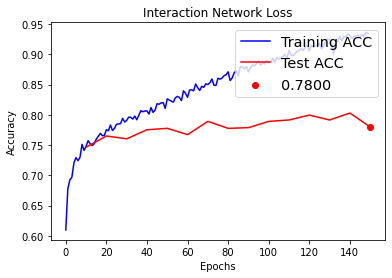

In [3]:
model = make_gcn(
    input_node_shape=[None,14],
    input_edge_shape=[None, 1],
    input_embedd={'input_node_vocab': 55, "input_node_embedd": 64},
    # Output
    output_embedd={"output_mode": 'graph', "output_type": 'padded'},
    output_mlp={"use_bias": [True, True, False], "units": [140, 70, 1], "activation": ['relu', 'relu', 'sigmoid']},
    # model specs
    depth=3,
    gcn_args={"units": 64, "use_bias": True, "activation": "relu", "has_unconnected": True, "is_sorted": False, "pooling_method": 'segment_mean'}
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = tf.keras.callbacks.LearningRateScheduler(lr_lin_reduction(learning_rate_start, learning_rate_stop, epomin, epo))
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_2.png')
plt.show()

## We have to implement the ExplainableGCN from the GNNInterface

In [4]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()

        # Here we modify the gcn model to allow node weights
        # This is a hacky solution. Ideally the model to explain offers weights as input by default.
        mlp_layer = gnn_model.layers[-1]
        config = mlp_layer.get_config()
        weights = mlp_layer.get_weights()
        cloned_layer = type(mlp_layer).from_config(config)
        pooling_layer = PoolingWeightedNodes()
        node_weights = tf.keras.layers.Input(shape=(None, 1), name='node_weights', dtype="float32", ragged=True)
        weighted_pooled = pooling_layer([model.layers[-3].output, node_weights])
        out = cloned_layer(weighted_pooled)
        inputs = model.inputs
        modified_model = tf.keras.Model(inputs=model.inputs + [node_weights], outputs=out)
        cloned_layer.set_weights(weights)
        self.gnn_model = modified_model

    def predict(self, gnn_input, masking_info=None):
        node_input, edge_input, edge_index_input = gnn_input
        node_weights = tf.RaggedTensor.from_row_splits(tf.expand_dims(tf.ones_like(node_input.values)[:,0],axis=-1), node_input.row_splits)
        return self.gnn_model([node_input, edge_input, edge_index_input, node_weights], training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input

        masked_edge_input = edge_mask * edge_input[0]
        masked_edge_input = tf.RaggedTensor.from_row_splits(masked_edge_input, [0, len(masked_edge_input)])
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32),
                                                         tf.transpose(feature_mask))
        node_weights = tf.RaggedTensor.from_row_splits(tf.sigmoid(node_mask), np.array([0, len(node_mask)],dtype=np.int))

        masked_pred = self.gnn_model([masked_feature_input, masked_edge_input, edge_index_input, node_weights],
                                     training=training)[0]
        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input.shape[2]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

In [5]:
# Instanciate a Explainable GNN:
explainable_gcn = ExplainableGCN(model)

In [6]:
# Find the 100 most mutagenic molecules, according to the GNN:
pred = model.predict(xtest)[:,0]
print(np.argsort(pred)[:100])

# Select instance to explain
instance_index = 297

[333 652 500  68  63 848 602 537  35 105 862 832 503 775 387 143  43 235
 260 379 709 653 272 699 134 859 103 554 635 689 584  41  26 524 116 762
 170 244 496 421 451 419 809 733 684 601 534  62 515 779 313 507 297 761
 106 233 553 549 649  55 361  85 512 467 176 760 100 412 187 367 443 405
 840 715 618 466 551 276 336 307  31 478 724 102 126 571 550 633  16  27
 808 264 284 749 202 416 363 777 811 703]


Setup an GNNExplainer and explain the instance:

In [8]:
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.1)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.005,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0.0001,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0.0001,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest])
#explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest], output_to_explain=tf.Variable([0.]))

C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer_2/model_1/pooling_weighted_nodes/RaggedTile/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/gnn_explainer_optimizer_2/model_1/pooling_weighted_nodes/RaggedTile/Reshape_2:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/gnn_explainer_optimizer_2/model_1/pooling_weighted_nodes/RaggedTile/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer_2/model_1/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gr

<Figure size 432x288 with 0 Axes>

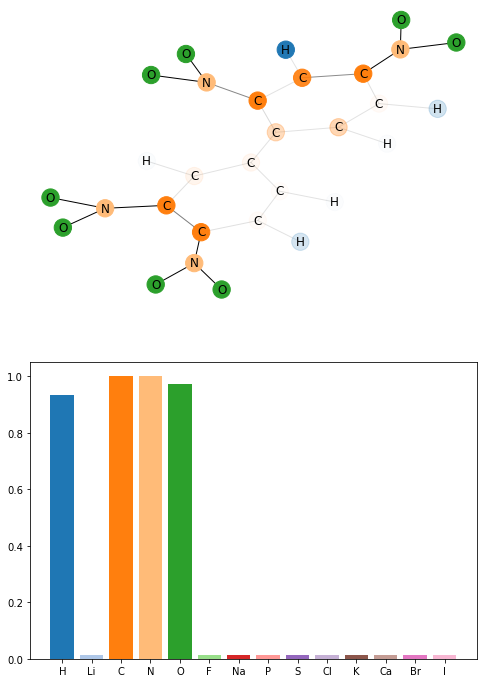

In [9]:
# Let's look at the explanation the GNNExplainer found:
plt.figure()
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()

If we do not specify the output_to_explain as parameter to the explain method the Explainer
will explain why the GNN came to its conclusion.
For molecules which are classified as non-mutagenic by the GNN,
the GNNExplainer will then explain why they are non-mutagenic.
We can also specify output_to_explain to be tf.Variable([0.]).
This way we can tell the Explainer to explain why a molecule could be mutagenic
even for molecules which are classified as most likely non-mutagenic by the GNN):

C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer_3/model_1/pooling_weighted_nodes/RaggedTile/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/gnn_explainer_optimizer_3/model_1/pooling_weighted_nodes/RaggedTile/Reshape_2:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/gnn_explainer_optimizer_3/model_1/pooling_weighted_nodes/RaggedTile/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer_3/model_1/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gr

<Figure size 432x288 with 0 Axes>

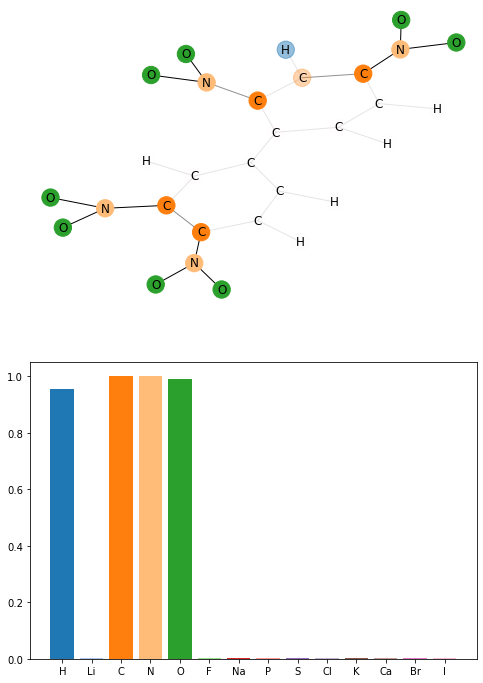

In [10]:
plt.figure()
explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest], output_to_explain=tf.Variable([0.]))
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()